# Use The Joker to explore long-period companion parameter space.

In [1]:
import os

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import radvel
import corner
import astropy.units as u

import pymc3 as pm
import exoplanet.units as xu
import exoplanet as xo

import schwimmbad
from twobody import KeplerOrbit, Barycenter
import thejoker as tj

%matplotlib inline

## Load the final search posteriors for test stars. Extract the RV data, and subtract the best-fit gamma offsets for the pre- and post-upgrade sets.

In [2]:
data = pd.read_csv('../rvdata/vst213472.csv')

In [3]:
time = np.asarray(data.jd)
mnvel = np.asarray(data.mnvel)
errvel = np.asarray(data.errvel)
# Make initial guess at jitter from HIRES errors.
jitter = np.median(errvel)

#Use correct units for RVs. Time is in days for TheJoker.
time   *= u.day
mnvel  *= u.m/u.s
errvel *= u.m/u.s
jitter *= u.m/u.s

In [4]:
data_j = data.query('tel == "j"')
data_k = data.query('tel == "k"')

time_j = np.asarray(data_j.jd)
mnvel_j = np.asarray(data_j.mnvel)# - np.median(data.mnvel))
errvel_j = np.asarray(data_j.errvel)
# Make initial guess at jitter from HIRES errors.
jitter_j = np.median(errvel_j)

#Use correct units for RVs. Time is in days for TheJoker.
time_j   *= u.day
mnvel_j  *= u.m/u.s
errvel_j *= u.m/u.s
jitter_j *= u.m/u.s

time_k = np.asarray(data_k.jd)
mnvel_k = np.asarray(data_k.mnvel)# - np.median(data.mnvel))
errvel_k = np.asarray(data_k.errvel)
# Make initial guess at jitter from HIRES errors.
jitter_k = np.median(errvel_k)

#Use correct units for RVs. Time is in days for TheJoker.
time_k   *= u.day
mnvel_k  *= u.m/u.s
errvel_k *= u.m/u.s
jitter_k *= u.m/u.s
#print(len(time_k) + len(time_j))

## Combine post- and pre- upgrade data, using best-fit offset.

In [7]:
rvdata   = tj.RVData(t=time, rv=mnvel, rv_err=errvel)
rvdata_j = tj.RVData(t=time_j, rv=mnvel_j, rv_err=errvel_j)
rvdata_k = tj.RVData(t=time_k, rv=mnvel_k, rv_err=errvel_k)

## Set up Joker object.

In [8]:
with pm.Model():
    dv0_1 = xu.with_unit(pm.Normal('dv0_1', 0, 5.), u.m/u.s)
    s = xu.with_unit(pm.Lognormal('s', 0, 0.5), u.m/u.s)
    baseline = np.amax(time_j) - np.amin(time_k)
    params = tj.JokerPrior.default(P_min=baseline, P_max=10*baseline, s=s,
                                   v0_offsets=[dv0_1], sigma_K0=1*u.km/u.s, sigma_v = 10*u.km/u.s)

In [9]:
%%time
 
prior_cache_file = 'prior_samples.hdf5'
if not os.path.exists(prior_cache_file):
    prior_samples = params.sample(2*10**4)
    prior_samples.write(prior_cache_file)
    
with schwimmbad.SerialPool() as pool: #SerialPool MultiPool
    joker = tj.TheJoker(params, pool=pool)
    samples = joker.rejection_sample([rvdata_j, rvdata_k], prior_cache_file)
    
os.remove(prior_cache_file)

CPU times: user 42.6 s, sys: 1min, total: 1min 43s
Wall time: 16 s


In [10]:
len(samples)

3

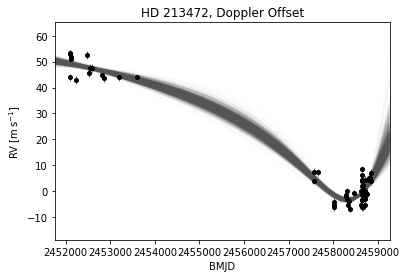

In [13]:
fig = tj.plot_rv_curves(samples, rv_unit=u.m/u.s, data=[rvdata_j, rvdata_k])
ax = fig.axes[0]
ax.set_title('HD 213472, Doppler Offset')
fig.savefig('213472_orbit_dopploff.png')

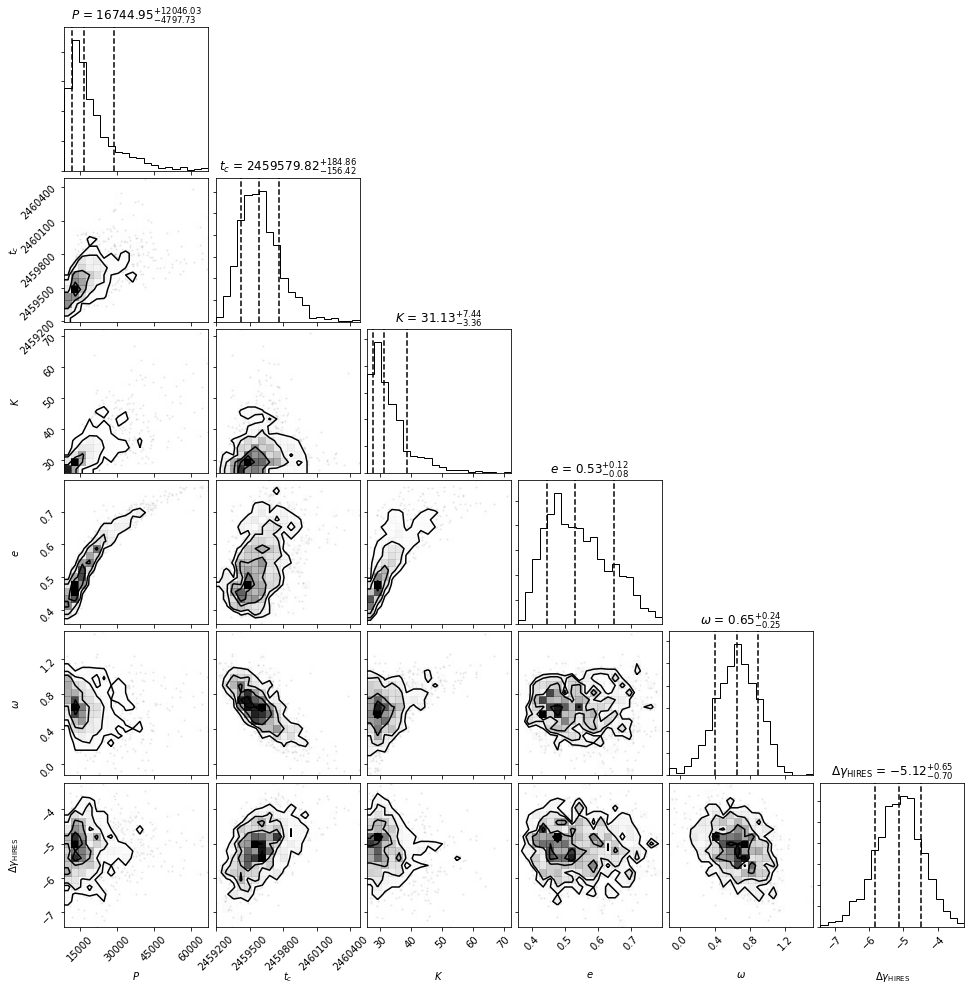

In [26]:
P = np.array(samples['P']/samples['P'].unit)
M0 = np.array(samples['M0']/samples['M0'].unit)
e = np.array(samples['e']/samples['e'].unit)
omega = np.array(samples['omega']/samples['omega'].unit)
jitter = np.array(samples['s']/samples['s'].unit)
K = np.array(samples['K']/samples['K'].unit)
v0 = np.array(samples['v0']/samples['v0'].unit)
dv0_1 = np.array(samples['dv0_1']/samples['dv0_1'].unit)

jchains = pd.DataFrame.from_dict({'P':P,'e':e, 'M0':M0, 'omega':omega,
                                  'K':np.abs(K), 'v0':v0, 'dv0_1':dv0_1})

#Fix phases of omega and M0.
wgood = jchains.query('abs(omega + 0.1) < 1.5')
wpos  = jchains.query('omega > 1.6')
wneg  = jchains.query('omega < -1.4')
wpos['omega'] -= np.pi
wneg['omega'] += np.pi
jchains = wgood.append(wpos, ignore_index=True).reset_index(drop=True)
jchains = jchains.append(wneg, ignore_index=True).reset_index(drop=True)

Mpos  = jchains.query('M0 > 0')
Mneg  = jchains.query('M0 < 0')
Mneg['M0'] += 2*np.pi
jchains = Mpos.append(Mneg, ignore_index=True).reset_index(drop=True)

# Convert phases to times of conjunction and periastron.
jchains['tper'] = np.array(data.jd[0]) + jchains['P']*jchains['M0']/(2*np.pi)
jchains['tc'] = radvel.orbit.timeperi_to_timetrans(jchains['tper'], jchains['P'], 
                                                   jchains['e'], jchains['omega'])

# Compute Msini and orbital separation.
mstar_213472  = 1.0450
umstar_213472 = 0.0713
starchain_213472 = np.random.normal(mstar_213472, umstar_213472, len(jchains)).clip(0.001, 100)
jchains['M'] = radvel.utils.Msini(jchains['K'], jchains['P'], starchain_213472, 
                                  jchains['e'], Msini_units='jupiter')
jchains['a'] = radvel.utils.semi_major_axis(jchains['P'], starchain_213472)

jchains = jchains[['K', 'P', 'e', 'M', 'a', 'tper', 'tc', 'omega', 'M0', 'v0', 'dv0_1']]
jchains.to_csv('Joker_results/213472_chains.csv')

#corners = ['P', 'a', 'tc', 'K', 'M', 'e', 'omega', 'dv0_1']
#labels = [r'$P$', r'$a$', r'$t_c$', r'$K$', r'$M$', r'$e$', r'$\omega$', r'$\Delta\gamma_{\mathrm{HIRES}}$']
corners = ['P', 'tc', 'K', 'e', 'omega', 'dv0_1']
labels = [r'$P$', r'$t_c$', r'$K$', r'$e$', r'$\omega$', r'$\Delta\gamma_{\mathrm{HIRES}}$']


fig = corner.corner(jchains[corners], labels=labels,
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 12})

fig.savefig('Joker_results/213472_corner_final.pdf')

## Do again, without first post-upgrade RV.

In [4]:
data_j = data.query('tel == "j" and jd > 2454000')
data_k = data.query('tel == "k"')

time_j = np.asarray(data_j.jd)
mnvel_j = np.asarray(data_j.mnvel)# - np.median(data.mnvel))
errvel_j = np.asarray(data_j.errvel)
# Make initial guess at jitter from HIRES errors.
jitter_j = np.median(errvel_j)

#Use correct units for RVs. Time is in days for TheJoker.
time_j   *= u.day
mnvel_j  *= u.m/u.s
errvel_j *= u.m/u.s
jitter_j *= u.m/u.s

time_k = np.asarray(data_k.jd)
mnvel_k = np.asarray(data_k.mnvel)# - np.median(data.mnvel))
errvel_k = np.asarray(data_k.errvel)
# Make initial guess at jitter from HIRES errors.
jitter_k = np.median(errvel_k)

#Use correct units for RVs. Time is in days for TheJoker.
time_k   *= u.day
mnvel_k  *= u.m/u.s
errvel_k *= u.m/u.s
jitter_k *= u.m/u.s

In [5]:
rvdata   = tj.RVData(t=time, rv=mnvel, rv_err=errvel)
rvdata_j = tj.RVData(t=time_j, rv=mnvel_j, rv_err=errvel_j)
rvdata_k = tj.RVData(t=time_k, rv=mnvel_k, rv_err=errvel_k)

In [6]:
with pm.Model():
    dv0_1 = xu.with_unit(pm.Normal('dv0_1', -50, 70.), u.m/u.s)
    s = xu.with_unit(pm.Lognormal('s', 0, 0.5), u.m/u.s)
    baseline = np.amax(time_j) - np.amin(time_k)
    params = tj.JokerPrior.default(P_min=baseline, P_max=10*baseline, s=s,
                                   v0_offsets=[dv0_1], sigma_K0=1*u.km/u.s, sigma_v = 10*u.km/u.s)

In [7]:
%%time
 
prior_cache_file = 'prior_samples.hdf5'
if not os.path.exists(prior_cache_file):
    prior_samples = params.sample(2*10**8)
    prior_samples.write(prior_cache_file)
    
with schwimmbad.SerialPool() as pool: #SerialPool MultiPool
    joker = tj.TheJoker(params, pool=pool)
    samples = joker.rejection_sample([rvdata_j, rvdata_k], prior_cache_file)
    
os.remove(prior_cache_file)

CPU times: user 4h 12min 17s, sys: 39.5 s, total: 4h 12min 57s
Wall time: 4h 12min 44s


In [8]:
len(samples)

1700

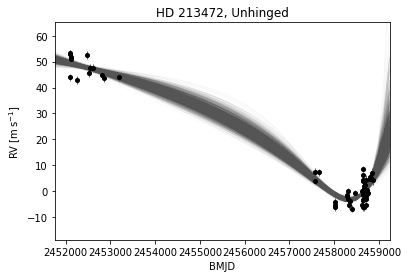

In [9]:
fig = tj.plot_rv_curves(samples, rv_unit=u.m/u.s, data=[rvdata_j, rvdata_k])
ax = fig.axes[0]
ax.set_title('HD 213472, Unhinged')
fig.savefig('Joker_results/213472_orbit_unhinged.png')

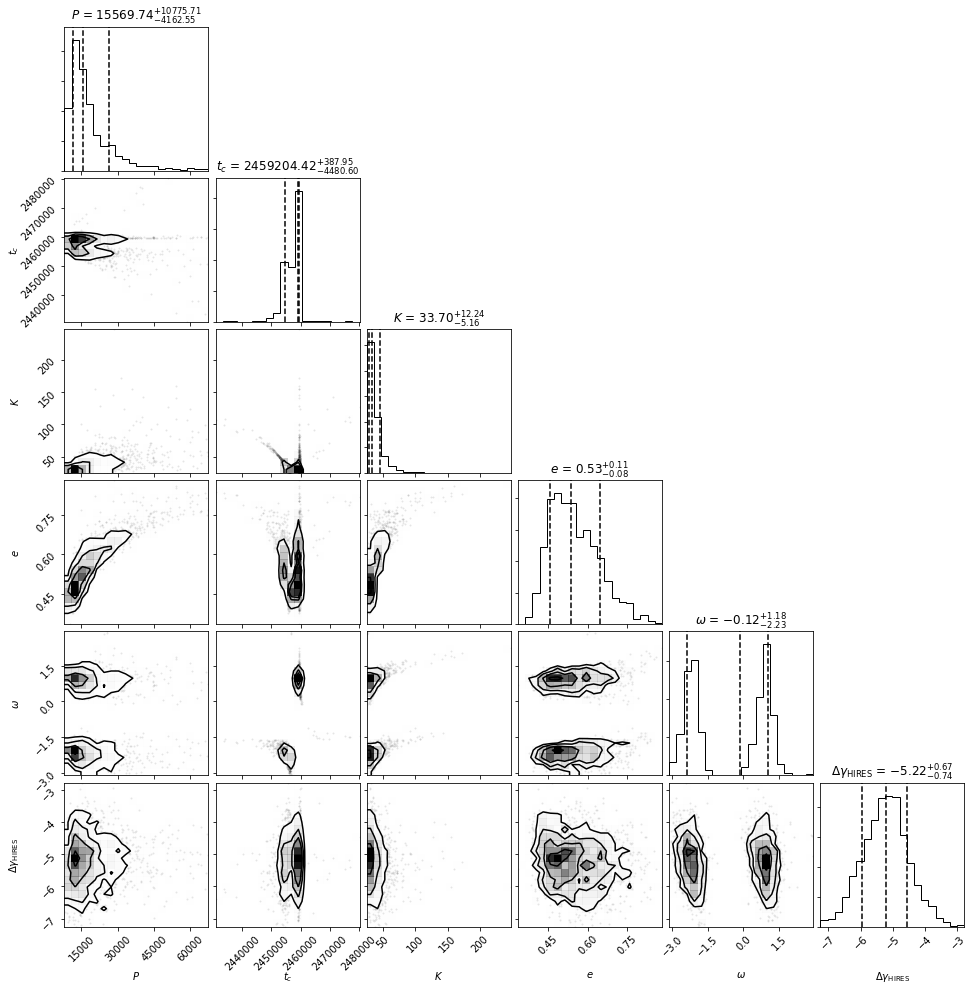

In [14]:
P = np.array(samples['P']/samples['P'].unit)
M0 = np.array(samples['M0']/samples['M0'].unit)
e = np.array(samples['e']/samples['e'].unit)
omega = np.array(samples['omega']/samples['omega'].unit)
jitter = np.array(samples['s']/samples['s'].unit)
K = np.array(samples['K']/samples['K'].unit)
v0 = np.array(samples['v0']/samples['v0'].unit)
dv0_1 = np.array(samples['dv0_1']/samples['dv0_1'].unit)

jchains = pd.DataFrame.from_dict({'P':P,'e':e, 'M0':M0, 'omega':omega,
                                  'K':np.abs(K), 'v0':v0, 'dv0_1':dv0_1})

#Fix phases of omega and M0.
'''
wgood = jchains.query('abs(omega + 0.1) < 1.5')
wpos  = jchains.query('omega > 1.6')
wneg  = jchains.query('omega < -1.4')
wpos['omega'] -= np.pi
wneg['omega'] += np.pi
jchains = wgood.append(wpos, ignore_index=True).reset_index(drop=True)
jchains = jchains.append(wneg, ignore_index=True).reset_index(drop=True)
'''
Mpos  = jchains.query('M0 > 0')
Mneg  = jchains.query('M0 < 0')
Mneg['M0'] += 2*np.pi
jchains = Mpos.append(Mneg, ignore_index=True).reset_index(drop=True)

# Convert phases to times of conjunction and periastron.
jchains['tper'] = np.array(data.jd[0]) + jchains['P']*jchains['M0']/(2*np.pi)
jchains['tc'] = radvel.orbit.timeperi_to_timetrans(jchains['tper'], jchains['P'], 
                                                   jchains['e'], jchains['omega'])

# Compute Msini and orbital separation.
mstar_213472  = 1.0450
umstar_213472 = 0.0713
starchain_213472 = np.random.normal(mstar_213472, umstar_213472, len(jchains)).clip(0.001, 100)
jchains['M'] = radvel.utils.Msini(jchains['K'], jchains['P'], starchain_213472, 
                                  jchains['e'], Msini_units='jupiter')
jchains['a'] = radvel.utils.semi_major_axis(jchains['P'], starchain_213472)

jchains = jchains[['K', 'P', 'e', 'M', 'a', 'tper', 'tc', 'omega', 'M0', 'v0', 'dv0_1']]
jchains.to_csv('Joker_results/213472_chains_unhinged.csv')

corners = ['P', 'tc', 'K', 'e', 'omega', 'dv0_1']
labels = [r'$P$', r'$t_c$', r'$K$', r'$e$', r'$\omega$', r'$\Delta\gamma_{\mathrm{HIRES}}$']


fig = corner.corner(jchains[corners], labels=labels,
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 12})

fig.savefig('Joker_results/213472_corner_unhinged.pdf')

## Do the same, for HD 26161.

In [4]:
data = pd.read_csv('../rvdata/vst26161.csv')

In [5]:
time = np.asarray(data.jd)
mnvel = np.asarray(data.mnvel)
errvel = np.asarray(data.errvel)
# Make initial guess at jitter from HIRES errors.
jitter = np.median(errvel)

#Use correct units for RVs. Time is in days for TheJoker.
time   *= u.day
mnvel  *= u.m/u.s
errvel *= u.m/u.s
jitter *= u.m/u.s

In [6]:
data_j = data.query('tel == "j"')
data_k = data.query('tel == "k"')

time_j = np.asarray(data_j.jd)
mnvel_j = np.asarray(data_j.mnvel)# - np.median(data.mnvel))
errvel_j = np.asarray(data_j.errvel)
# Make initial guess at jitter from HIRES errors.
jitter_j = np.median(errvel_j)

#Use correct units for RVs. Time is in days for TheJoker.
time_j   *= u.day
mnvel_j  *= u.m/u.s
errvel_j *= u.m/u.s
jitter_j *= u.m/u.s

time_k = np.asarray(data_k.jd)
mnvel_k = np.asarray(data_k.mnvel)# - np.median(data.mnvel))
errvel_k = np.asarray(data_k.errvel)
# Make initial guess at jitter from HIRES errors.
jitter_k = np.median(errvel_k)

#Use correct units for RVs. Time is in days for TheJoker.
time_k   *= u.day
mnvel_k  *= u.m/u.s
errvel_k *= u.m/u.s
jitter_k *= u.m/u.s
print(len(time_k) + len(time_j))

50


In [7]:
# Set up Joker data object.
rvdata   = tj.RVData(t=time, rv=mnvel, rv_err=errvel)
rvdata_j = tj.RVData(t=time_j, rv=mnvel_j, rv_err=errvel_j)
rvdata_k = tj.RVData(t=time_k, rv=mnvel_k, rv_err=errvel_k)

In [8]:
with pm.Model():
    dv0_1 = xu.with_unit(pm.Normal('dv0_1', 0, 5.), u.m/u.s)
    s = xu.with_unit(pm.Lognormal('s', 0, 0.5), u.m/u.s)
    baseline = np.amax(time_j) - np.amin(time_k)
    params = tj.JokerPrior.default(P_min=1.2*baseline, P_max=10*baseline, s=s,
                                   v0_offsets=[dv0_1], sigma_K0=1*u.km/u.s, sigma_v = 10*u.km/u.s)
print(10*baseline)

80660.72565809824 d


In [9]:
%%time

prior_cache_file = 'prior_samples.hdf5'
if not os.path.exists(prior_cache_file):
    prior_samples = params.sample(2*10**8)
    prior_samples.write(prior_cache_file)
else:
    pass

with schwimmbad.SerialPool() as pool:
    joker = tj.TheJoker(params, pool=pool)
    samples = joker.rejection_sample([rvdata_j, rvdata_k], prior_cache_file)
    
os.remove(prior_cache_file) 

CPU times: user 3h 11s, sys: 44.9 s, total: 3h 56s
Wall time: 3h 29s


In [10]:
print(len(samples))
samples

90


<JokerSamples [P, e, omega, M0, s, K, v0, dv0_1] (90 samples)>

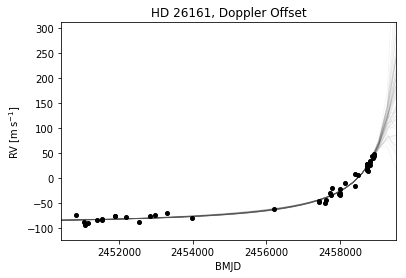

In [67]:
fig = tj.plot_rv_curves(samples, rv_unit=u.m/u.s, data=[rvdata_j, rvdata_k])
ax = fig.axes[0]
ax.set_title('HD 26161, Doppler Offset')
fig.savefig('Joker_results/26161_orbit_sample.pdf')

In [11]:
P = np.array(samples['P']/samples['P'].unit)
M0 = np.array(samples['M0']/samples['M0'].unit)
e = np.array(samples['e']/samples['e'].unit)
omega = np.array(samples['omega']/samples['omega'].unit)

#jitter = np.array(samples['jitter']/samples['jitter'].unit)
K = np.abs(np.array(samples['K']/samples['K'].unit))
v0 = np.array(samples['v0']/samples['v0'].unit)
dv0_1 = np.array(samples['dv0_1']/samples['dv0_1'].unit)

#'M0':M0, 'omega':omega

jchains = pd.DataFrame.from_dict({'P':P, 'e':e, 'omega':omega, 'M0':M0,
                                  'K':K, 'v0':v0, 'dv0_1':dv0_1})
#jchains['tp'] = np.amin(time)/u.day + jchains['P']*jchains['M0']/(2*np.pi)
jchains.to_csv('Joker_results/26161_chains_sample.csv')

## Combine 26161 chains, remake the corner plot.

In [12]:
part1_26161 = pd.read_csv('Joker_results/26161_chains_sample1.csv')
part2_26161 = pd.read_csv('Joker_results/26161_chains_sample2.csv')
part3_26161 = pd.read_csv('Joker_results/26161_chains_sample3.csv')
part4_26161 = pd.read_csv('Joker_results/26161_chains_sample4.csv')
part5_26161 = pd.read_csv('Joker_results/26161_chains_sample5.csv')
part6_26161 = pd.read_csv('Joker_results/26161_chains_sample6.csv')
part7_26161 = pd.read_csv('Joker_results/26161_chains_sample7.csv')
part8_26161 = pd.read_csv('Joker_results/26161_chains_sample8.csv')
part9_26161 = pd.read_csv('Joker_results/26161_chains_sample9.csv')
part10_26161 = pd.read_csv('Joker_results/26161_chains_sample10.csv')
part11_26161 = pd.read_csv('Joker_results/26161_chains_sample11.csv')
part12_26161 = pd.read_csv('Joker_results/26161_chains_sample12.csv')
part13_26161 = pd.read_csv('Joker_results/26161_chains_sample13.csv')
part14_26161 = pd.read_csv('Joker_results/26161_chains_sample14.csv')
part15_26161 = pd.read_csv('Joker_results/26161_chains_sample15.csv')
part16_26161 = pd.read_csv('Joker_results/26161_chains_sample16.csv')

full_26161 = part1_26161.append(part2_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part3_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part4_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part5_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part6_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part7_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part8_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part9_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part10_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part11_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part12_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part13_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part14_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part15_26161, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(part16_26161, ignore_index=True).reset_index(drop=True)

wgood = full_26161.query('abs(omega) < 1.57')
wpos  = full_26161.query('omega > 1.57')
wneg  = full_26161.query('omega < -1.57')
wpos['omega'] -= np.pi
wneg['omega'] += np.pi
full_26161 = wgood.append(wpos, ignore_index=True).reset_index(drop=True)
full_26161 = full_26161.append(wneg, ignore_index=True).reset_index(drop=True)

mgood = full_26161.query('M0 > 0')
mbad = full_26161.query('M0 < 0')
mbad['M0'] += 2*np.pi
full_26161 = mgood.append(mbad, ignore_index=True).reset_index(drop=True)

full_26161['tper'] = np.array(data.jd[0]) + full_26161['P']*full_26161['M0']/(2*np.pi)
full_26161['tc'] = radvel.orbit.timeperi_to_timetrans(full_26161['tper'], full_26161['P'], 
                                                      full_26161['e'], full_26161['omega'])

# Compute Msini and orbital separation.
mstar_26161   = 1.1126
umstar_26161  = 0.0755
starchain_26161 = np.random.normal(mstar_26161, umstar_26161, len(full_26161)).clip(0.001, 100)
full_26161['M'] = radvel.utils.Msini(full_26161['K'], full_26161['P'], starchain_26161, 
                                  full_26161['e'], Msini_units='jupiter')
full_26161['a'] = radvel.utils.semi_major_axis(full_26161['P'], starchain_26161)

full_26161 = full_26161[['K', 'P', 'e', 'M', 'a', 'tper', 'tc', 'omega', 'M0', 'v0', 'dv0_1']]
full_26161.to_csv('Joker_results/26161_chains_combined.csv')

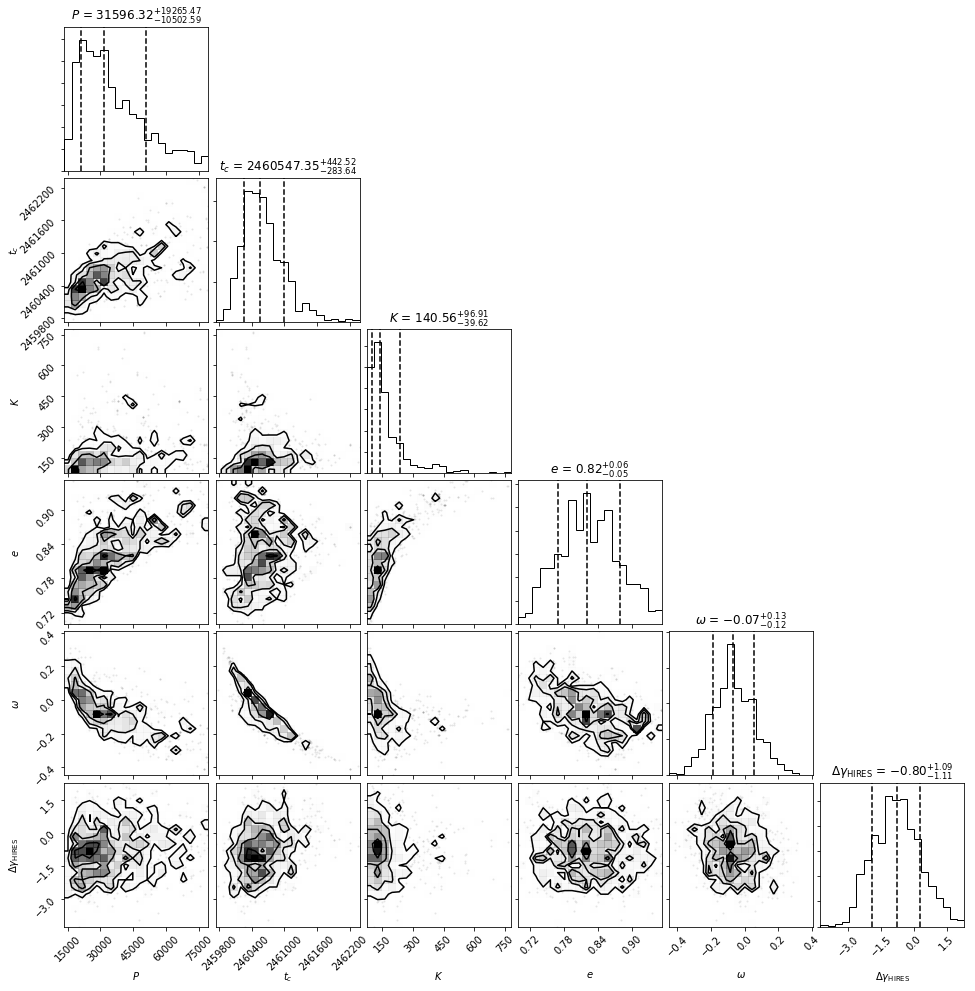

In [13]:
corners = ['P', 'tc', 'K', 'e', 'omega', 'dv0_1']
labels = [r'$P$', r'$t_c$', r'$K$', r'$e$', r'$\omega$', r'$\Delta\gamma_{\mathrm{HIRES}}$']

fig = corner.corner(full_26161[corners], labels=labels,
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 12})
fig.savefig('Joker_results/26161_corner_sample.pdf')

### Do the same for 66428. Subtract the inner planet signature.

In [4]:
data = pd.read_csv('../rvdata/vst66428.csv')

post = radvel.posterior.load('../setup_tests/66428/post_final.pkl')
orbel = [post.params['per1'].value,
         post.params['tp1'].value,
         post.params['e1'].value,
         post.params['w1'].value,
         post.params['k1'].value]
mod = radvel.kepler.rv_drive(data['jd'].values, orbel)

#Subtract off signal of inner planet.
time = np.asarray(data.jd)
mnvel = np.asarray(data.mnvel - mod)
errvel = np.asarray(data.errvel)
# Make initial guess at jitter from HIRES errors.
jitter = np.median(errvel)

#Use correct units for RVs. Time is in days for TheJoker.
time   *= u.day
mnvel  *= u.m/u.s
errvel *= u.m/u.s
jitter *= u.m/u.s

data_j = data.query('tel == "j"')
data_k = data.query('tel == "k"')


time_j = np.asarray(data_j.jd)
mnvel_j = np.asarray(data_j.mnvel)# - np.median(data.mnvel))
errvel_j = np.asarray(data_j.errvel)
# Make initial guess at jitter from HIRES errors.
jitter_j = np.median(errvel_j)

#Use correct units for RVs. Time is in days for TheJoker.
time_j   *= u.day
mnvel_j  *= u.m/u.s
errvel_j *= u.m/u.s
jitter_j *= u.m/u.s

time_k = np.asarray(data_k.jd)
mnvel_k = np.asarray(data_k.mnvel)# - np.median(data.mnvel))
errvel_k = np.asarray(data_k.errvel)
# Make initial guess at jitter from HIRES errors.
jitter_k = np.median(errvel_k)

#Use correct units for RVs. Time is in days for TheJoker.
time_k   *= u.day
mnvel_k  *= u.m/u.s
errvel_k *= u.m/u.s
jitter_k *= u.m/u.s
print(len(time_k) + len(time_j))

72


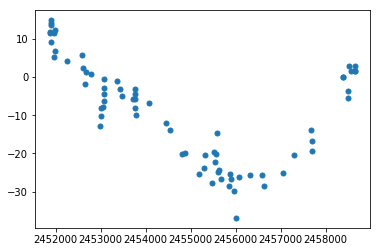

In [5]:
fig, ax = plt.subplots()
ax.scatter(time, mnvel)

In [6]:
rvdata   = tj.RVData(t=time, rv=mnvel, rv_err=errvel)
rvdata_j = tj.RVData(t=time_j, rv=mnvel_j, rv_err=errvel_j)
rvdata_k = tj.RVData(t=time_k, rv=mnvel_k, rv_err=errvel_k)

with pm.Model():
    dv0_1 = xu.with_unit(pm.Normal('dv0_1', 0, 7.), u.m/u.s)
    s = xu.with_unit(pm.Lognormal('s', 0, 0.5), u.m/u.s)
    baseline = np.amax(time_j) - np.amin(time_k)
    params = tj.JokerPrior.default(P_min=1.2*baseline, P_max=15*baseline, s=s,
                                   v0_offsets=[dv0_1], sigma_K0=1*u.km/u.s, sigma_v = 10*u.km/u.s)
print(10*baseline)

67646.88334609848 d


In [8]:
%%time

prior_cache_file = 'prior_samples.hdf5'
if not os.path.exists(prior_cache_file):
    prior_samples = params.sample(2*10**6)
    prior_samples.write(prior_cache_file)
else:
    pass

with schwimmbad.SerialPool() as pool:
    joker = tj.TheJoker(params, pool=pool)
    samples = joker.rejection_sample([rvdata_j, rvdata_k], prior_cache_file)
    
os.remove(prior_cache_file) 

CPU times: user 1h 31min 8s, sys: 1h 45min 21s, total: 3h 16min 29s
Wall time: 27min 57s


In [10]:
P = np.array(samples['P']/samples['P'].unit)
M0 = np.array(samples['M0']/samples['M0'].unit)
e = np.array(samples['e']/samples['e'].unit)
omega = np.array(samples['omega']/samples['omega'].unit)
jitter = np.array(samples['s']/samples['s'].unit)
K = np.array(samples['K']/samples['K'].unit)
v0 = np.array(samples['v0']/samples['v0'].unit)
dv0_1 = np.array(samples['dv0_1']/samples['dv0_1'].unit)

jchains = pd.DataFrame.from_dict({'P':P,'e':e, 'M0':M0, 'omega':omega,
                                  'K':np.abs(K), 'v0':v0, 'dv0_1':dv0_1})

#Fix phases of omega and M0.
'''
wgood = jchains.query('abs(omega + 0.1) < 1.5')
wpos  = jchains.query('omega > 1.6')
wneg  = jchains.query('omega < -1.4')
wpos['omega'] -= np.pi
wneg['omega'] += np.pi
jchains = wgood.append(wpos, ignore_index=True).reset_index(drop=True)
jchains = jchains.append(wneg, ignore_index=True).reset_index(drop=True)
'''
Mpos  = jchains.query('M0 > 0')
Mneg  = jchains.query('M0 < 0')
Mneg['M0'] += 2*np.pi
jchains = Mpos.append(Mneg, ignore_index=True).reset_index(drop=True)

# Convert phases to times of conjunction and periastron.
jchains['tper'] = np.array(data.jd[0]) + jchains['P']*jchains['M0']/(2*np.pi)
jchains['tc'] = radvel.orbit.timeperi_to_timetrans(jchains['tper'], jchains['P'], 
                                                   jchains['e'], jchains['omega'])

# Compute Msini and orbital separation.
mstar_66428  = 1.0450
umstar_66428 = 0.0713
starchain_66428 = np.random.normal(mstar_66428, umstar_66428, len(jchains)).clip(0.001, 100)
jchains['M'] = radvel.utils.Msini(jchains['K'], jchains['P'], starchain_66428, 
                                  jchains['e'], Msini_units='jupiter')
jchains['a'] = radvel.utils.semi_major_axis(jchains['P'], starchain_66428)

jchains = jchains[['K', 'P', 'e', 'M', 'a', 'tper', 'tc', 'omega', 'M0', 'v0', 'dv0_1']]
jchains.to_csv('Joker_results/66428_chains.csv')

corners = ['P', 'tc', 'K', 'e', 'omega', 'dv0_1']
labels = [r'$P$', r'$t_c$', r'$K$', r'$e$', r'$\omega$', r'$\Delta\gamma_{\mathrm{HIRES}}$']


fig = corner.corner(jchains[corners], labels=labels,
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 12})

fig.savefig('Joker_results/66428_corner.pdf')

AssertionError: I don't believe that you want more dimensions than samples!

In [11]:
len(jchains)

1

In [12]:
jchains

,K,P,e,M,a,tper,tc,omega,M0,v0,dv0_1
0,44.364185,8578.606562,0.802032,2.602664,8.098818,2.454506e+06,2.454873e+06,-0.360516,1.909419,3.304562,-8.366048


## Load posteriors and stellar masses, and compute physical parameter chains. For each parameter, compute the posterior maximum, median, and quantiles.

In [37]:
chain_26161  = pd.read_csv('Joker_results/26161_chains_combined.csv')
chain_213472 = pd.read_csv('Joker_results/213472_chains.csv')
'''
mstar_26161   = 1.1126
umstar_26161  = 0.0755
mstar_213472  = 1.0450
umstar_213472 = 0.0713
starchain_213472 = np.random.normal(mstar_213472, umstar_213472, len(chain_213472)).clip(0.001, 100)
chain_213472['M'] = radvel.utils.Msini(chain_213472['K'], chain_213472['P'], starchain_213472, 
                                  chain_213472['e'], Msini_units='jupiter')
chain_213472['a'] = radvel.utils.semi_major_axis(chain_213472['P'], starchain_213472)
chain_213472.to_csv('Joker_results/213472_chains_0109.csv')
starchain_26161 = np.random.normal(mstar_26161, umstar_26161, len(chain_26161)).clip(0.001, 100)
chain_26161['M'] = radvel.utils.Msini(chain_26161['K'], chain_26161['P'], starchain_26161, 
                                  chain_26161['e'], Msini_units='jupiter')
chain_26161['a'] = radvel.utils.semi_major_axis(chain_26161['P'], starchain_26161)
chain_26161.to_csv('Joker_results/26161_chains_combined.csv')
'''
print(chain_213472.columns)

Index(['Unnamed: 0', 'K', 'P', 'e', 'M', 'a', 'tper', 'tc', 'omega', 'M0',
       'v0', 'dv0_1'],
      dtype='object')


### One star at a time. 26161, then 213472.

In [39]:
ks_26161 = np.asarray(chain_26161['K'])
es_26161 = np.asarray(chain_26161['e'])
pers_26161 = np.asarray(chain_26161['P'])
tcs_26161 = np.asarray(chain_26161['tc'])
tps_26161 = np.asarray(chain_26161['tper'])
ws_26161 = np.asarray(chain_26161['omega'])
masses_26161 = np.asarray(chain_26161['M'])
axes_26161 = np.asarray(chain_26161['a'])


k_26161 = stats.mode(ks_26161)
e_26161 = stats.mode(es_26161)
per_26161 = stats.mode(pers_26161)
tc_26161  = stats.mode(tcs_26161)
tp_26161  = stats.mode(tps_26161)
w_26161   = stats.mode(ws_26161)
mass_26161 = stats.mode(masses_26161)
axis_26161 = stats.mode(axes_26161)

k_med_26161 = np.median(ks_26161)
e_med_26161 = np.median(es_26161)
per_med_26161 = np.median(pers_26161)
tc_med_26161  = np.median(tcs_26161)
tp_med_26161  = np.median(tps_26161)
w_med_26161 = np.median(ws_26161)
mass_med_26161 = np.median(masses_26161)
axis_med_26161 = np.median(axes_26161)

k_min_26161 = np.percentile(ks_26161, 15.9)
e_min_26161 = np.percentile(es_26161, 15.9)
per_min_26161 = np.percentile(pers_26161, 15.9)
tc_min_26161  = np.percentile(tcs_26161, 15.9)
tp_min_26161  = np.percentile(tps_26161, 15.9)
w_min_26161 = np.percentile(ws_26161, 15.9)
mass_min_26161 = np.percentile(masses_26161, 15.9)
axis_min_26161 = np.percentile(axes_26161, 15.9)

k_plus_26161 = np.percentile(ks_26161, 84.1)
e_plus_26161 = np.percentile(es_26161, 84.1)
per_plus_26161 = np.percentile(pers_26161, 84.1)
tc_plus_26161  = np.percentile(tcs_26161, 84.1)
tp_plus_26161  = np.percentile(tps_26161, 84.1)
w_plus_26161 = np.percentile(ws_26161, 84.1)
mass_plus_26161 = np.percentile(masses_26161, 84.1)
axis_plus_26161 = np.percentile(axes_26161, 84.1)

print('26161')
print('k:', k_min_26161, k_med_26161, k_plus_26161)
print('e:', e_min_26161, e_med_26161, e_plus_26161)
print('per:', per_min_26161, per_med_26161, per_plus_26161)
print('tc:', tc_min_26161, tc_med_26161, tc_plus_26161)
print('tp:', tp_min_26161, tp_med_26161, tp_plus_26161)
print('w:', w_min_26161, w_med_26161, w_plus_26161)
print('mass:', mass_min_26161, mass_med_26161, mass_plus_26161)
print('axis:', axis_min_26161, axis_med_26161, axis_plus_26161)

26161
k: 100.70356304430058 140.43470770782488 238.1213765036606
e: 0.7696436232245163 0.8204703718342015 0.8811394525430307
per: 21249.304231543996 31732.98816514587 53035.48532110475
tc: 2461338.893539641 2461621.208174122 2462077.0701839863
tp: 2460744.4917762787 2460898.198285536 2461046.1020728317
w: -0.19459757029008 -0.07258102780410257 0.058156889941236384
mass: 9.836825263692972 13.52379199820353 21.991682750043005
axis: 15.582455518571468 20.45159135347918 28.316687229421138


In [35]:
ks_213472 = np.asarray(chain_213472['K'])
es_213472 = np.asarray(chain_213472['e'])
pers_213472 = np.asarray(chain_213472['P'])
tcs_213472 = np.asarray(chain_213472['tc'])
tps_213472 = np.asarray(chain_213472['tper'])
ws_213472 = np.asarray(chain_213472['omega'])
masses_213472 = np.asarray(chain_213472['M'])
axes_213472 = np.asarray(chain_213472['a'])


k_213472 = stats.mode(ks_213472)
e_213472 = stats.mode(es_213472)
per_213472 = stats.mode(pers_213472)
tc_213472  = stats.mode(tcs_213472)
tp_213472  = stats.mode(tps_213472)
w_213472   = stats.mode(ws_213472)
mass_213472 = stats.mode(masses_213472)
axis_213472 = stats.mode(axes_213472)

k_med_213472 = np.median(ks_213472)
e_med_213472 = np.median(es_213472)
per_med_213472 = np.median(pers_213472)
tc_med_213472  = np.median(tcs_213472)
tp_med_213472  = np.median(tps_213472)
mass_med_213472 = np.median(masses_213472)
axis_med_213472 = np.median(axes_213472)

k_min_213472 = np.percentile(ks_213472, 15.9)
e_min_213472 = np.percentile(es_213472, 15.9)
per_min_213472 = np.percentile(pers_213472, 15.9)
tc_min_213472  = np.percentile(tcs_213472, 15.9)
tp_min_213472  = np.percentile(tps_213472, 15.9)
mass_min_213472 = np.percentile(masses_213472, 15.9)
axis_min_213472 = np.percentile(axes_213472, 15.9)

k_plus_213472 = np.percentile(ks_213472, 84.1)
e_plus_213472 = np.percentile(es_213472, 84.1)
per_plus_213472 = np.percentile(pers_213472, 84.1)
tc_plus_213472  = np.percentile(tcs_213472, 84.1)
tp_plus_213472  = np.percentile(tps_213472, 84.1)
mass_plus_213472 = np.percentile(masses_213472, 84.1)
axis_plus_213472 = np.percentile(axes_213472, 84.1)

In [36]:
print('213472')
print('k:', k_min_213472, k_med_213472, k_plus_213472)
print('e:', e_min_213472, e_med_213472, e_plus_213472)
print('per:', per_min_213472, per_med_213472, per_plus_213472)
print('tc:', tc_min_213472, tc_med_213472, tc_plus_213472)
print('tp:', tp_min_213472, tp_med_213472, tp_plus_213472)
print('mass:', mass_min_213472, mass_med_213472, mass_plus_213472)
print('axis:', axis_min_213472, axis_med_213472, axis_plus_213472)

213472
k: 27.768347776403033 31.132454903599314 38.61993901235222
e: 0.4443397461477272 0.5290556165320334 0.6493562714690058
per: 11939.171717882055 16744.9511136867 28844.636513757374
tc: 2459423.2776919985 2459579.819233378 2459766.25492228
tp: 2458651.5215969994 2458839.2736846367 2459008.8144448115
mass: 2.8845148175054245 3.4792747870300977 4.553364865564593
axis: 10.393463173664305 12.990679995335505 18.742690902196003


## Explore the trend of HD 34721.

In [2]:
data = pd.read_csv('../rvdata/vst34721.csv')

In [5]:
time = np.asarray(data.jd)
mnvel = np.asarray(data.mnvel)
errvel = np.asarray(data.errvel)
# Make initial guess at jitter from HIRES errors.
jitter = np.median(errvel)

#Use correct units for RVs. Time is in days for TheJoker.
time   *= u.day
mnvel  *= u.m/u.s
errvel *= u.m/u.s
jitter *= u.m/u.s

data_j = data.query('tel == "j"')
data_k = data.query('tel == "k"')

time_j = np.asarray(data_j.jd)
mnvel_j = np.asarray(data_j.mnvel)# - np.median(data.mnvel))
errvel_j = np.asarray(data_j.errvel)
# Make initial guess at jitter from HIRES errors.
jitter_j = np.median(errvel_j)

#Use correct units for RVs. Time is in days for TheJoker.
time_j   *= u.day
mnvel_j  *= u.m/u.s
errvel_j *= u.m/u.s
jitter_j *= u.m/u.s

time_k = np.asarray(data_k.jd)
mnvel_k = np.asarray(data_k.mnvel)# - np.median(data.mnvel))
errvel_k = np.asarray(data_k.errvel)
# Make initial guess at jitter from HIRES errors.
jitter_k = np.median(errvel_k)

#Use correct units for RVs. Time is in days for TheJoker.
time_k   *= u.day
mnvel_k  *= u.m/u.s
errvel_k *= u.m/u.s
jitter_k *= u.m/u.s

In [6]:
rvdata   = tj.RVData(t=time, rv=mnvel, rv_err=errvel)
rvdata_j = tj.RVData(t=time_j, rv=mnvel_j, rv_err=errvel_j)
rvdata_k = tj.RVData(t=time_k, rv=mnvel_k, rv_err=errvel_k)

In [53]:
with pm.Model():
    dv0_1 = xu.with_unit(pm.Normal('dv0_1', 0, 10.), u.m/u.s)
    s = xu.with_unit(pm.Lognormal('s', 0, 0.5), u.m/u.s)
    baseline = np.amax(time_j) - np.amin(time_k)
    params = tj.JokerPrior.default(P_min=baseline, P_max=50*baseline, s=s,
                                   v0_offsets=[dv0_1], sigma_K0=2*u.km/u.s, sigma_v = 10*u.km/u.s)

In [13]:
%%time
 
prior_cache_file = 'prior_samples.hdf5'
if not os.path.exists(prior_cache_file):
    prior_samples = params.sample(2*10**6)
    prior_samples.write(prior_cache_file)
    
with schwimmbad.SerialPool() as pool: #SerialPool MultiPool
    joker = tj.TheJoker(params, pool=pool)
    samples = joker.rejection_sample([rvdata_j, rvdata_k], prior_cache_file)
    
os.remove(prior_cache_file)

CPU times: user 1h 49min 17s, sys: 2h 8min 41s, total: 3h 57min 58s
Wall time: 33min 41s


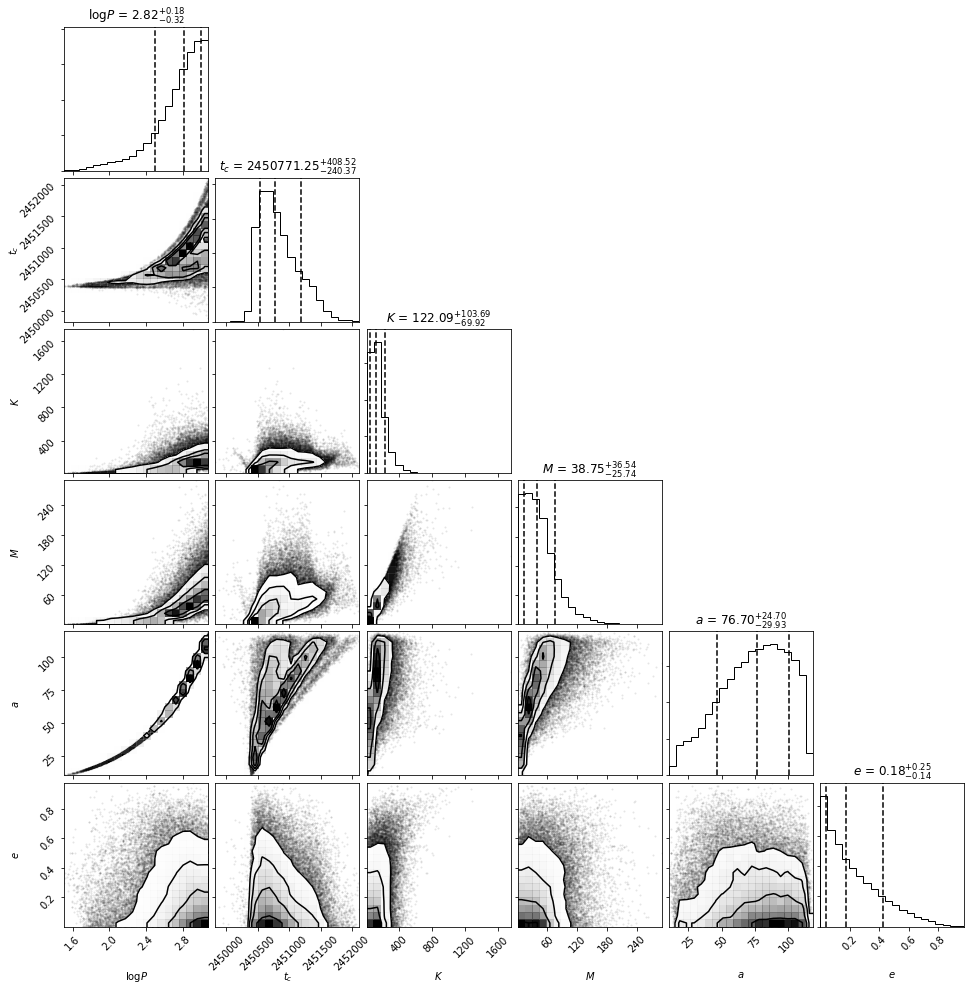

In [63]:
P = np.array(samples['P']/samples['P'].unit)/365.25
M0 = np.array(samples['M0']/samples['M0'].unit)
e = np.array(samples['e']/samples['e'].unit)
omega = np.array(samples['omega']/samples['omega'].unit)
jitter = np.array(samples['s']/samples['s'].unit)
K = np.array(samples['K']/samples['K'].unit)
v0 = np.array(samples['v0']/samples['v0'].unit)
dv0_1 = np.array(samples['dv0_1']/samples['dv0_1'].unit)

jchains = pd.DataFrame.from_dict({'P':P,'e':e, 'M0':M0, 'omega':omega,
                                  'K':np.abs(K), 'v0':v0, 'dv0_1':dv0_1})

#Fix phases of omega and M0.
wgood = jchains.query('abs(omega + 0.1) < 1.5')
wpos  = jchains.query('omega > 1.6')
wneg  = jchains.query('omega < -1.4')
wpos['omega'] -= np.pi
wneg['omega'] += np.pi
jchains = wgood.append(wpos, ignore_index=True).reset_index(drop=True)
jchains = jchains.append(wneg, ignore_index=True).reset_index(drop=True)

Mpos  = jchains.query('M0 > 0')
Mneg  = jchains.query('M0 < 0')
Mneg['M0'] += 2*np.pi
jchains = Mpos.append(Mneg, ignore_index=True).reset_index(drop=True)

# Convert phases to times of conjunction and periastron.
jchains['tper'] = np.array(data.jd[0]) + jchains['P']*jchains['M0']/(2*np.pi)
jchains['tc'] = radvel.orbit.timeperi_to_timetrans(jchains['tper'], jchains['P'], 
                                                   jchains['e'], jchains['omega'])

jchains['logP'] = np.log10(jchains['P'])

# Compute Msini and orbital separation.
mstar_34721  = 1.05
umstar_34721 = 0.05
starchain_34721 = np.random.normal(mstar_34721, umstar_34721, len(jchains)).clip(0.001, 100)
jchains['M'] = radvel.utils.Msini(jchains['K'], jchains['P']*365.25, starchain_34721, 
                                  jchains['e'], Msini_units='jupiter')
jchains['a'] = radvel.utils.semi_major_axis(jchains['P']*365.25, starchain_34721)

jchains = jchains[['K', 'P', 'logP', 'e', 'M', 'a', 'tper', 'tc', 'omega', 'M0', 'v0', 'dv0_1']]
#jchains.to_csv('Joker_results/34721_chains.csv')

#corners = ['P', 'a', 'tc', 'K', 'M', 'e', 'omega', 'dv0_1']
#labels = [r'$P$', r'$a$', r'$t_c$', r'$K$', r'$M$', r'$e$', r'$\omega$', r'$\Delta\gamma_{\mathrm{HIRES}}$']
corners = ['logP', 'tc', 'K', 'M', 'a', 'e',]# 'omega', 'dv0_1']
labels = [r'log$P$', r'$t_c$', r'$K$', r'$M$', r'$a$', r'$e$']#, r'$\omega$', r'$\Delta\gamma_{\mathrm{HIRES}}$']


fig = corner.corner(jchains[corners], labels=labels,
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 12})

fig.savefig('Joker_results/34721_corner.pdf')

### Check BIC test between Keplerian and linear trend. First for 31427, then for 26161.

In [42]:
def initialize_linear_model():
    time_base = np.median(data.jd)
    params = radvel.Parameters(1,basis='per tc secosw sesinw k') # number of planets = 2
    params['per1'] = radvel.Parameter(value=100, vary=False)
    params['tc1'] = radvel.Parameter(value=711, vary=False)
    params['secosw1'] = radvel.Parameter(value=0.01, vary=False)
    params['sesinw1'] = radvel.Parameter(value=0.01, vary=False)
    params['k1'] = radvel.Parameter(value=0., vary=False)
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=0.0001, vary=True)
    mod.params['curv'] = radvel.Parameter(value=0, vary=False)
    return mod

mod = initialize_linear_model()
like = radvel.likelihood.RVLikelihood(mod, data.jd, data.mnvel, data.errvel)
like.params['gamma'] = radvel.Parameter(value=0.1, vary=False, linear=True)
like.params['jit'] = radvel.Parameter(value=1.0)

linear_post = radvel.posterior.Posterior(like)
linear_post = radvel.fitting.maxlike_fitting(linear_post, verbose=False)

In [43]:
linear_post

parameter                     value      vary
per1                            100      False
tc1                             711      False
secosw1                        0.01      False
sesinw1                        0.01      False
k1                                0      False
dvdt                      0.0022141       True
curv                              0      False
gamma                      -2.79791      False
jit                         3.76892       True
tp1                         698.505           
e1                           0.0002           
w1                         0.785398           

Priors
------

In [44]:
linear_BIC = linear_post.likelihood.bic()

In [45]:
def initialize_model():
    time_base = np.median(data.jd)
    params = radvel.Parameters(1,basis='per tc secosw sesinw k') # number of planets = 2
    params['per1'] = radvel.Parameter(value=16000, vary=True)
    params['tc1'] = radvel.Parameter(value=711, vary=True)
    params['secosw1'] = radvel.Parameter(value=0.01, vary=True)
    params['sesinw1'] = radvel.Parameter(value=0.01, vary=True)
    params['k1'] = radvel.Parameter(value=12., vary=True)
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=0, vary=False)
    mod.params['curv'] = radvel.Parameter(value=0, vary=False)
    return mod

In [46]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, data.jd, data.mnvel, data.errvel)
like.params['gamma'] = radvel.Parameter(value=0.1, vary=False, linear=True)
like.params['jit'] = radvel.Parameter(value=1.0)

kepler_post = radvel.posterior.Posterior(like)

In [47]:
kepler_post = radvel.fitting.maxlike_fitting(kepler_post, verbose=False)

In [48]:
kepler_post

parameter                     value      vary
per1                        15984.4       True
tc1                         1559.52       True
secosw1                    0.284889       True
sesinw1                    0.707927       True
k1                          17.5658       True
dvdt                              0      False
curv                              0      False
gamma                     -0.696967      False
jit                         3.76478       True
tp1                         1346.84           
e1                         0.582323           
w1                           1.1882           

Priors
------

In [37]:
kepler_BIC = kepler_post.likelihood.bic()

In [49]:
print(kepler_BIC, ', ', linear_BIC, ', ', kepler_BIC - linear_BIC)

586.954234097235 ,  569.2764614709901 ,  17.677772626244973


In [55]:
print(kepler_post.likelihood.neglogprob(), ', ', linear_post.likelihood.neglogprob())#, ', ', kepler_BIC - linear_BIC)

279.75298411310735 ,  280.06351975699164


In [29]:
data = pd.read_csv('../rvdata/vst26161.csv').query('tel=="j" or tel=="k"').reset_index(drop=True)

def initialize_quadratic_model():
    time_base = np.median(data.jd)
    params = radvel.Parameters(1,basis='per tc secosw sesinw k') # number of planets = 2
    params['per1'] = radvel.Parameter(value=100, vary=False)
    params['tc1'] = radvel.Parameter(value=711, vary=False)
    params['secosw1'] = radvel.Parameter(value=0.01, vary=False)
    params['sesinw1'] = radvel.Parameter(value=0.01, vary=False)
    params['k1'] = radvel.Parameter(value=0., vary=False)
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=0.0001, vary=True)
    mod.params['curv'] = radvel.Parameter(value=0.0001, vary=True)
    return mod

mod = initialize_quadratic_model()
like = radvel.likelihood.RVLikelihood(mod, data.jd, data.mnvel, data.errvel)
like.params['gamma_j'] = radvel.Parameter(value=0.1, vary=False, linear=True)
like.params['gamma_k'] = radvel.Parameter(value=0.1, vary=False, linear=True)
like.params['jit_j'] = radvel.Parameter(value=1.0)
like.params['jit_k'] = radvel.Parameter(value=1.0)

quad_post = radvel.posterior.Posterior(like)
quad_post = radvel.fitting.maxlike_fitting(quad_post, verbose=False)
quad_BIC = quad_post.likelihood.bic()

AssertionError: Length of array must match number of varied parameters

In [4]:
quad_post.likelihood.params['jit_j']

Parameter object: value = 3.61803065717419, vary = True, mcmc scale = None

In [7]:
quad_post

parameter                     value      vary
per1                            100      False
tc1                             711      False
secosw1                        0.01      False
sesinw1                        0.01      False
k1                                0      False
dvdt                        2.61813       True
curv                        2.61813       True
gamma_j                         0.1      False
gamma_k                         0.1      False
jit_j                       3.61803       True
jit_k                       3.61803       True
gamma                           nan       True
jit                             nan       True
tp1                         698.505           
e1                           0.0002           
w1                         0.785398           

Priors
------

In [ ]:
def initialize_kepler_model():
    time_base = np.median(data.jd)
    params = radvel.Parameters(1,basis='per tc secosw sesinw k') # number of planets = 2
    params['per1'] = radvel.Parameter(value=15600, vary=True)
    params['tc1'] = radvel.Parameter(value=2459706, vary=True)
    params['secosw1'] = radvel.Parameter(value=0.8448797, vary=True)
    params['sesinw1'] = radvel.Parameter(value=0.2191836, vary=True)
    params['k1'] = radvel.Parameter(value=92.83, vary=True)
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=0, vary=False)
    mod.params['curv'] = radvel.Parameter(value=0, vary=False)
    return mod

mod = initialize_kepler_model()

telgrps = data.groupby('tel').groups
likes = []
def initialize(tel_suffix):
    # Instantiate a separate likelihood object for each instrument.
    # Each likelihood must use the same radvel.RVModel object.
    indices = telgrps[tel_suffix]
    like = radvel.likelihood.RVLikelihood(mod, data.jd[indices], data.mnvel[indices], data.errvel[indices])
    like.params['gamma_'+tel_suffix] = radvel.Parameter(value=np.mean(data.mnvel[indices]), vary=True, linear=True)
    like.params['jit_'+tel_suffix] = radvel.Parameter(value=0.1, vary=True)
    #like.params['gamma'] = radvel.Parameter(value=np.mean(data.mnvel[indices]), vary=False, linear=False)
    #like.params['jit'] = radvel.Parameter(value=0.1, vary=False)
    likes.append(like)
initialize('j')
initialize('k')

In [37]:
kepler_post = radvel.posterior.Posterior(like)
kepler_post.likelihood.params = 

Parameters([('per1',
             Parameter object: value = 100, vary = False, mcmc scale = None),
            ('tc1',
             Parameter object: value = 711, vary = False, mcmc scale = None),
            ('secosw1',
             Parameter object: value = 0.01, vary = False, mcmc scale = None),
            ('sesinw1',
             Parameter object: value = 0.01, vary = False, mcmc scale = None),
            ('k1',
             Parameter object: value = 0.0, vary = False, mcmc scale = None),
            ('dvdt',
             Parameter object: value = 0.0001, vary = True, mcmc scale = None),
            ('curv',
             Parameter object: value = 0.0001, vary = True, mcmc scale = None),
            ('gamma',
             Parameter object: value = nan, vary = True, mcmc scale = None),
            ('jit',
             Parameter object: value = nan, vary = True, mcmc scale = None),
            ('gamma_j',
             Parameter object: value = 0.1, vary = False, mcmc scale = None),


In [34]:
kepler_post = radvel.posterior.Posterior(like)
kepler_post = radvel.fitting.maxlike_fitting(kepler_post, verbose=False)
kepler_BIC = kepler_post.likelihood.bic()

AssertionError: Length of array must match number of varied parameters

In [32]:
kepler_post

parameter                     value      vary
per1                        34793.3       True
tc1                         1750.99       True
secosw1                    0.880877       True
sesinw1                    0.248996       True
k1                          85.7141       True
dvdt                              0      False
curv                              0      False
gamma                       -82.277      False
jit                             0.1      False
gamma_j                     371.106       True
jit_j                       374.118       True
gamma_k                     291.741       True
jit_k                       374.118       True
tp1                         1288.29           
e1                         0.837944           
w1                         0.275481           

Priors
------

In [33]:
kepler_BIC

744.0886721624901

In [25]:
print(kepler_BIC, ', ', quad_BIC, ', ', kepler_BIC - quad_BIC)

419.29553378031545 ,  413.37251587206526 ,  5.923017908250188


In [26]:
np.std(kepler_post.likelihood.residuals())

12.158657205105216

In [20]:
np.std(quad_post.likelihood.residuals())

383.4304674779286